# Import Libraries

In [55]:
%pip install --upgrade scikit-learn
%pip install python-dotenv
%pip install influxdb-client
%pip install pandas
%pip install pyyaml
%pip install numpy
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [56]:
import io
import os
import time
import yaml
import warnings
import pandas as pd
import json
import hashlib
import matplotlib.pyplot as plt
import csv
from influxdb_client import InfluxDBClient
from influxdb_client.client.warnings import MissingPivotFunction
from dotenv import load_dotenv

import numpy as np
from functools import partial

warnings.simplefilter("ignore", MissingPivotFunction)

load_dotenv()

False

# Import Dataset

In [57]:
df_digi = pd.read_csv('Data/dataset.csv') #Digi Luar, Selasar
df_dosen = pd.read_csv('Data/dosen.csv') # Ruangan Dosen, Selasar Luar
df_sc = pd.read_csv('Data/student_corner.csv') # Student Corner
df_eltron = pd.read_csv('Data/half eltron.csv') # Half Eltron
df_selasar = pd.read_csv('Data/selasar.csv') # Selasar dalem + Digi dalem
df_final = pd.read_csv('Data/final.csv') # Half eltron, belakang sc

# df_digi cleaning

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
C:\Users\laure\AppData\Local\Temp\ipykernel_7728\2382845006.py:6: SyntaxWarning: invalid escape sequence '\d'
  frequency_df['rp_number'] = frequency_df['reference_point'].str.extract('(\d+)').astype(int)


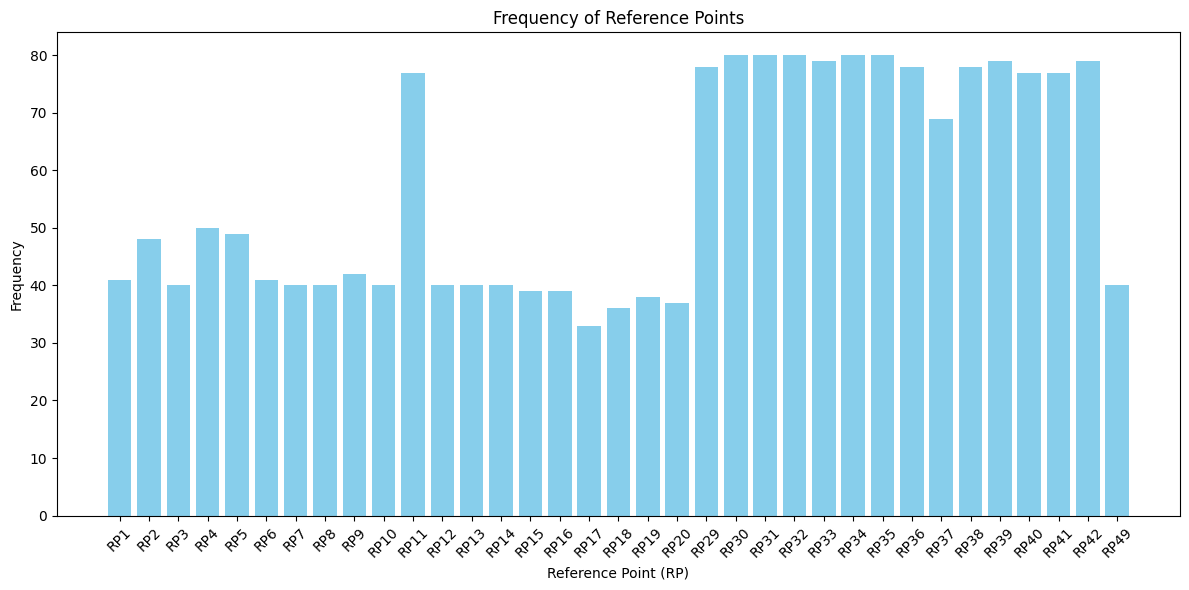

In [58]:
frequency = df_digi['reference_point'].value_counts()

frequency_df = frequency.reset_index()
frequency_df.columns = ['reference_point', 'frequency']

frequency_df['rp_number'] = frequency_df['reference_point'].str.extract('(\d+)').astype(int)
frequency_df = frequency_df.sort_values(by='rp_number')

plt.figure(figsize=(12, 6))
plt.bar(frequency_df['reference_point'], frequency_df['frequency'], color='skyblue')
plt.xlabel('Reference Point (RP)')
plt.ylabel('Frequency')
plt.title('Frequency of Reference Points')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [59]:
df_digi = df_digi[~df_digi["reference_point"].str.contains("RP49", na=False)]

In [60]:
df_digi.columns

Index(['Unnamed: 0', 'bssid', 'channel', 'host', 'iteration',
       'reference_point', 'rssi', 'ssid', 'time', 'topic', 'xr', 'yr'],
      dtype='object')

# df_dosen cleaning

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
C:\Users\laure\AppData\Local\Temp\ipykernel_7728\2140566733.py:6: SyntaxWarning: invalid escape sequence '\d'
  frequency_df['rp_number'] = frequency_df['reference_point'].str.extract('(\d+)').astype(int)


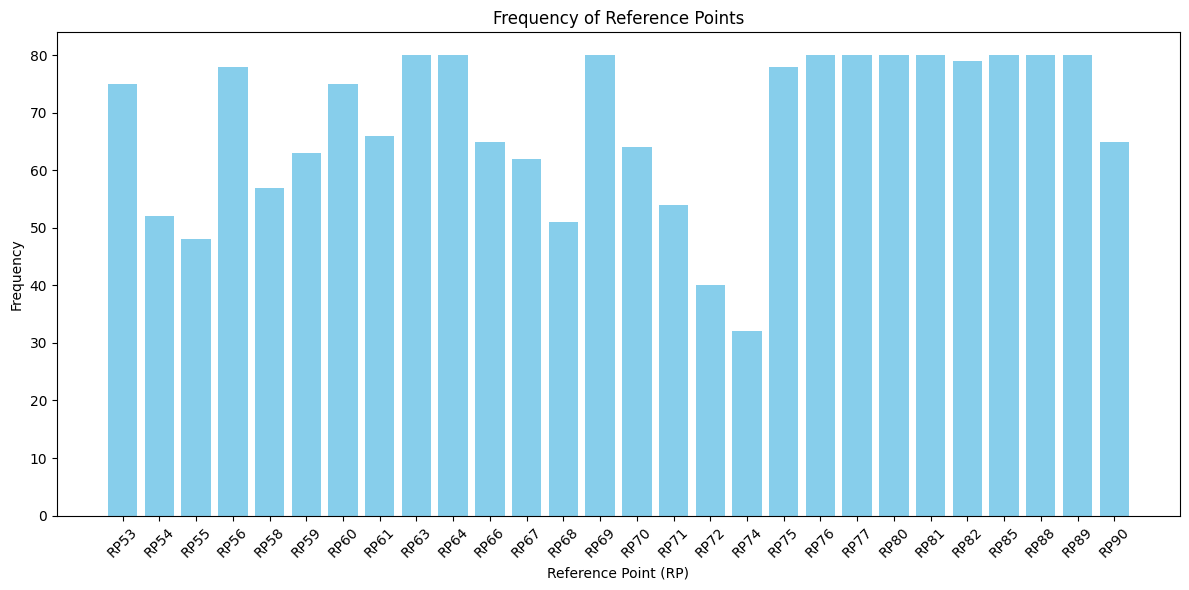

In [61]:
frequency = df_dosen['reference_point'].value_counts()

frequency_df = frequency.reset_index()
frequency_df.columns = ['reference_point', 'frequency']

frequency_df['rp_number'] = frequency_df['reference_point'].str.extract('(\d+)').astype(int)
frequency_df = frequency_df.sort_values(by='rp_number')

plt.figure(figsize=(12, 6))
plt.bar(frequency_df['reference_point'], frequency_df['frequency'], color='skyblue')
plt.xlabel('Reference Point (RP)')
plt.ylabel('Frequency')
plt.title('Frequency of Reference Points')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [62]:
df_dosen = df_dosen[~df_dosen["reference_point"].str.contains("RP49", na=False)] # ruang pak pur

# df_sc cleaning

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
C:\Users\laure\AppData\Local\Temp\ipykernel_7728\3388794265.py:6: SyntaxWarning: invalid escape sequence '\d'
  frequency_df['rp_number'] = frequency_df['reference_point'].str.extract('(\d+)').astype(int)


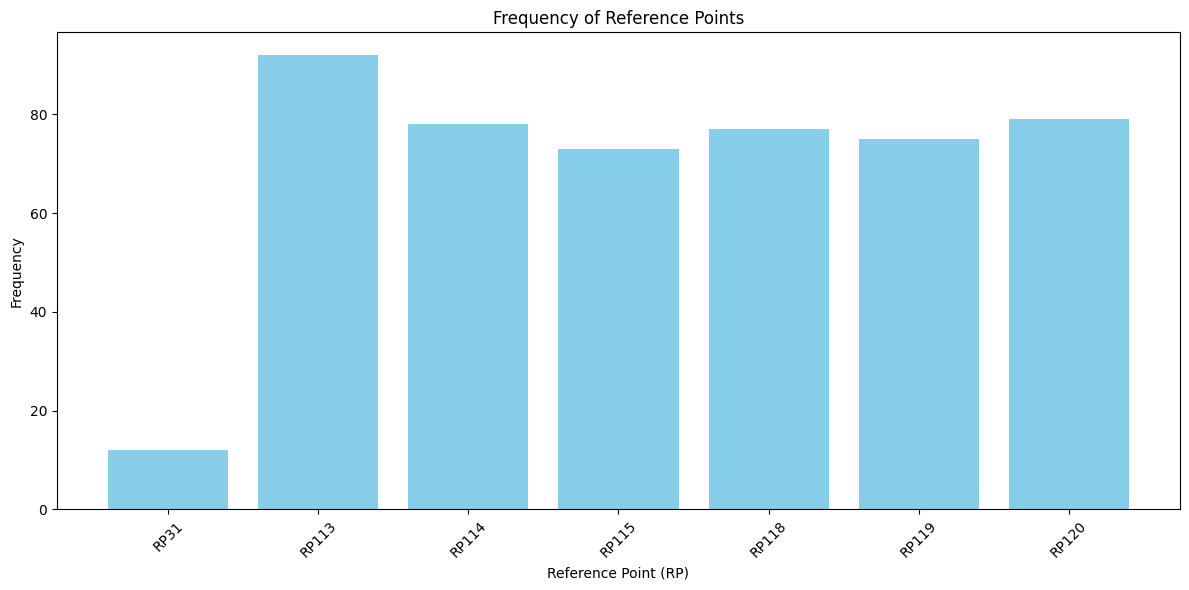

In [63]:
frequency = df_sc['reference_point'].value_counts()

frequency_df = frequency.reset_index()
frequency_df.columns = ['reference_point', 'frequency']

frequency_df['rp_number'] = frequency_df['reference_point'].str.extract('(\d+)').astype(int)
frequency_df = frequency_df.sort_values(by='rp_number')

plt.figure(figsize=(12, 6))
plt.bar(frequency_df['reference_point'], frequency_df['frequency'], color='skyblue')
plt.xlabel('Reference Point (RP)')
plt.ylabel('Frequency')
plt.title('Frequency of Reference Points')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [64]:
df_sc = df_sc[~df_sc["reference_point"].str.contains("RP31", na=False)]

# df_eltron cleaning

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
C:\Users\laure\AppData\Local\Temp\ipykernel_7728\4245151233.py:6: SyntaxWarning: invalid escape sequence '\d'
  frequency_df['rp_number'] = frequency_df['reference_point'].str.extract('(\d+)').astype(int)


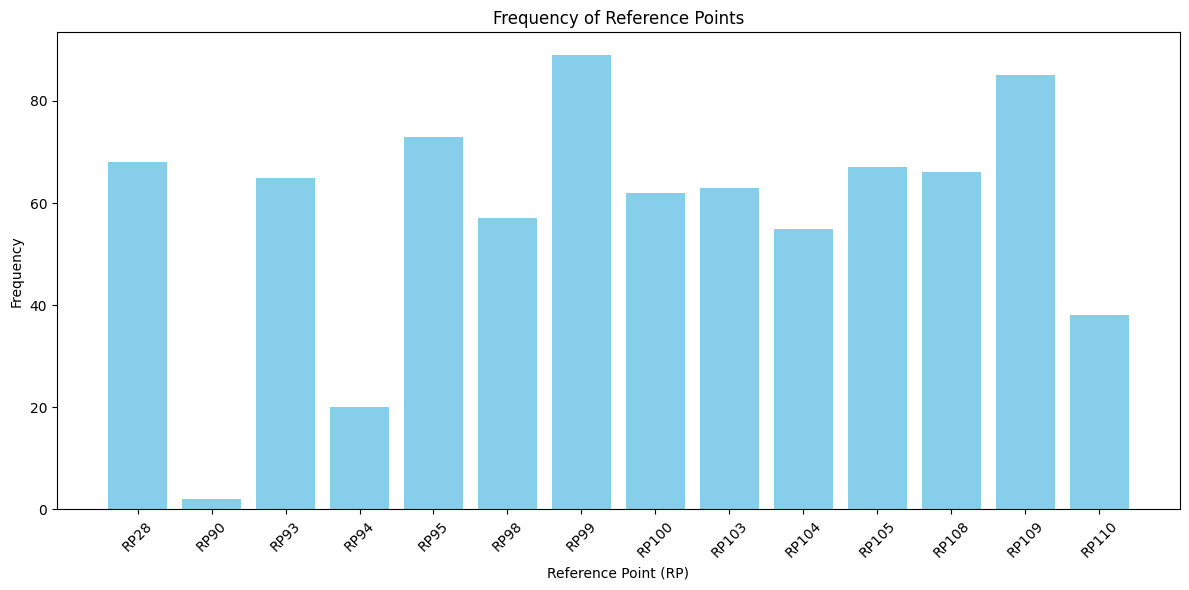

In [65]:
frequency = df_eltron['reference_point'].value_counts()

frequency_df = frequency.reset_index()
frequency_df.columns = ['reference_point', 'frequency']

frequency_df['rp_number'] = frequency_df['reference_point'].str.extract('(\d+)').astype(int)
frequency_df = frequency_df.sort_values(by='rp_number')

plt.figure(figsize=(12, 6))
plt.bar(frequency_df['reference_point'], frequency_df['frequency'], color='skyblue')
plt.xlabel('Reference Point (RP)')
plt.ylabel('Frequency')
plt.title('Frequency of Reference Points')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [66]:
df_eltron = df_eltron[~df_eltron["reference_point"].str.contains("RP90", na=False)]
df_eltron = df_eltron[~df_eltron["reference_point"].str.contains("RP94", na=False)]

# df_selasar cleaning

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
C:\Users\laure\AppData\Local\Temp\ipykernel_7728\1957272588.py:6: SyntaxWarning: invalid escape sequence '\d'
  frequency_df['rp_number'] = frequency_df['reference_point'].str.extract('(\d+)').astype(int)


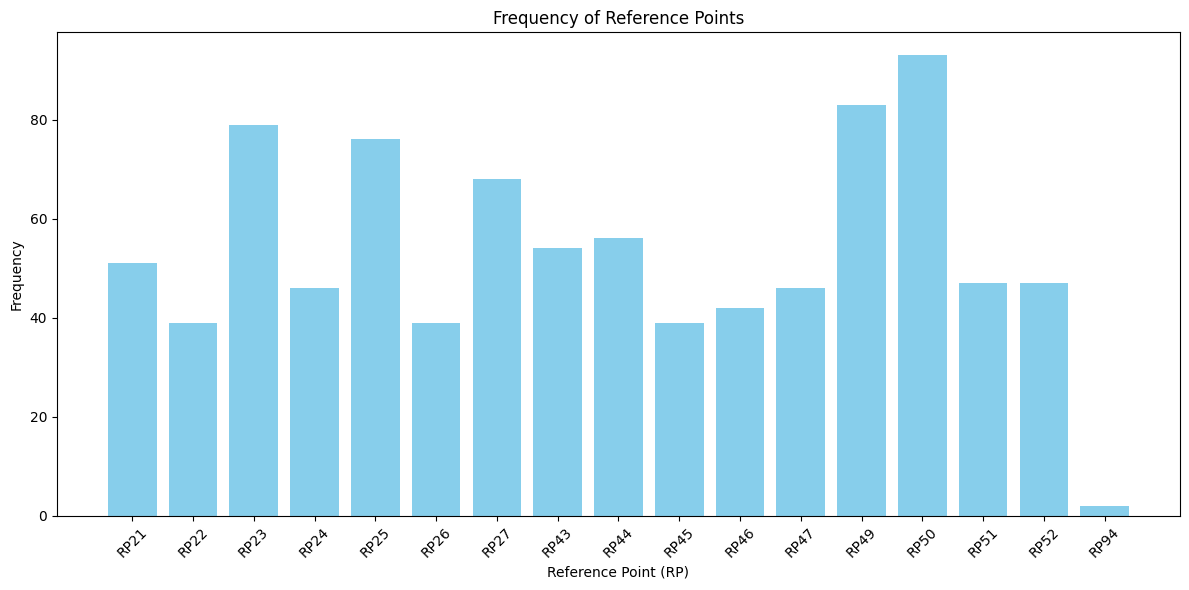

In [67]:
frequency = df_selasar['reference_point'].value_counts()

frequency_df = frequency.reset_index()
frequency_df.columns = ['reference_point', 'frequency']

frequency_df['rp_number'] = frequency_df['reference_point'].str.extract('(\d+)').astype(int)
frequency_df = frequency_df.sort_values(by='rp_number')

plt.figure(figsize=(12, 6))
plt.bar(frequency_df['reference_point'], frequency_df['frequency'], color='skyblue')
plt.xlabel('Reference Point (RP)')
plt.ylabel('Frequency')
plt.title('Frequency of Reference Points')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [68]:
# Cleaning from invalid data
df_selasar = df_selasar[~df_selasar["reference_point"].str.contains("RP50", na=False)]
df_selasar = df_selasar[~df_selasar["reference_point"].str.contains("RP94", na=False)]
df_selasar = df_selasar[~df_selasar["reference_point"].str.contains("RP49", na=False)]

# df_final cleaning

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
C:\Users\laure\AppData\Local\Temp\ipykernel_7728\2648192120.py:6: SyntaxWarning: invalid escape sequence '\d'
  frequency_df['rp_number'] = frequency_df['reference_point'].str.extract('(\d+)').astype(int)


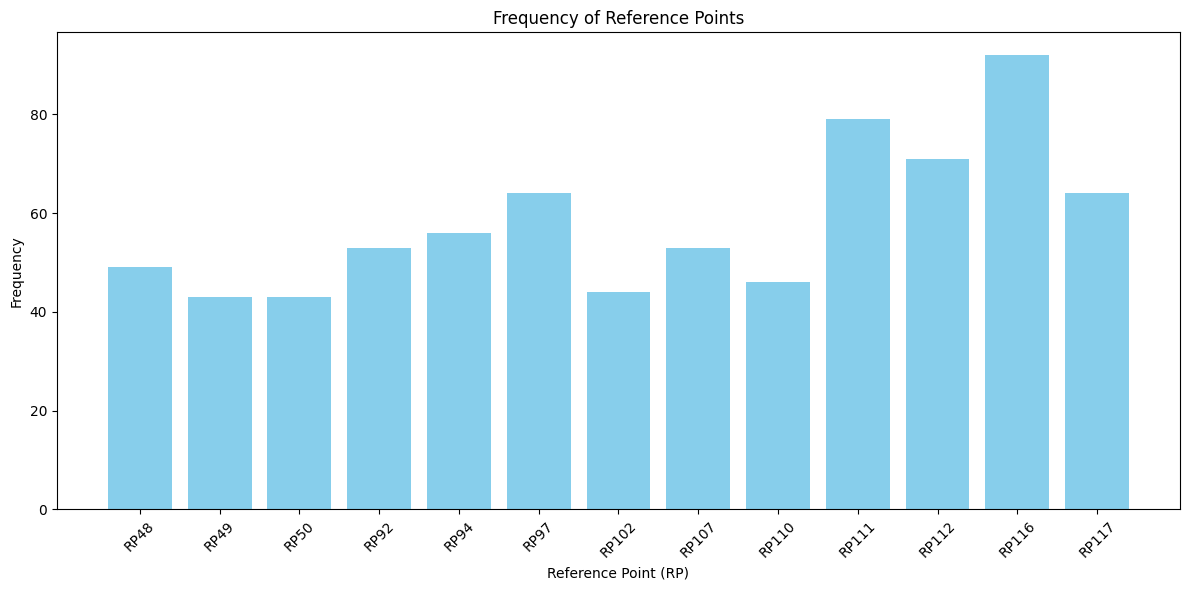

In [69]:
frequency = df_final['reference_point'].value_counts()

frequency_df = frequency.reset_index()
frequency_df.columns = ['reference_point', 'frequency']

frequency_df['rp_number'] = frequency_df['reference_point'].str.extract('(\d+)').astype(int)
frequency_df = frequency_df.sort_values(by='rp_number')

plt.figure(figsize=(12, 6))
plt.bar(frequency_df['reference_point'], frequency_df['frequency'], color='skyblue')
plt.xlabel('Reference Point (RP)')
plt.ylabel('Frequency')
plt.title('Frequency of Reference Points')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [70]:
df = pd.concat([df_digi, df_dosen, df_sc, df_eltron, df_selasar, df_final], ignore_index=True)

In [71]:
df.head()

,Unnamed: 0,bssid,channel,host,iteration,reference_point,rssi,ssid,time,topic,xr,yr
0,NaN,70:A7:41:DC:8E:55,1,LAUREN,1,RP29,-92,DTE Staff,2024-10-17T10:19:36.0867022Z,esp/topic,989,1037
1,NaN,70:A7:41:DC:8E:55,1,LAUREN,10,RP29,-94,DTE Staff,2024-10-17T10:23:26.6782315Z,esp/topic,989,1037
2,NaN,70:A7:41:DC:8E:55,1,LAUREN,11,RP29,-94,DTE Staff,2024-10-17T10:23:51.8041404Z,esp/topic,989,1037
3,NaN,70:A7:41:DC:8E:55,1,LAUREN,12,RP29,-90,DTE Staff,2024-10-17T10:24:13.6954786Z,esp/topic,989,1037
4,NaN,70:A7:41:DC:8E:55,1,LAUREN,13,RP29,-91,DTE Staff,2024-10-17T10:24:38.6661326Z,esp/topic,989,1037


In [72]:
df.columns

Index(['Unnamed: 0', 'bssid', 'channel', 'host', 'iteration',
       'reference_point', 'rssi', 'ssid', 'time', 'topic', 'xr', 'yr'],
      dtype='object')

## Drop Unnecessary Columns

In [73]:
df = df.drop(columns=['Unnamed: 0','host', 'topic'])

In [74]:
df.sample(10)

,bssid,channel,iteration,reference_point,rssi,ssid,time,xr,yr
6527,70:A7:41:DC:77:CD,6,2,RP94,-65,DTE Staff,2025-03-12T03:53:33.4656572Z,520,639
5532,70:A7:41:DC:77:CD,6,8,RP47,-61,DTE Staff,2025-03-11T07:49:03.5880913Z,1168,2130
5479,70:A7:41:DC:77:CD,6,4,RP51,-67,DTE Staff,2025-03-11T07:31:55.1517552Z,1341,1948
763,72:A7:41:9C:77:CD,11,17,RP12,-64,DTE Student,2024-10-23T03:02:29.2317175Z,759,1567
4155,72:A7:41:9C:8E:55,11,7,RP114,-78,DTE IoT,2025-02-25T03:49:46.4272834Z,1290,639
464,70:A7:41:DC:77:CD,11,16,RP5,-66,DTE Staff,2024-10-17T09:31:43.3291128Z,300,2130
3633,72:A7:41:9C:8E:55,11,18,RP82,-78,DTE IoT,2025-03-01T02:15:52.4060362Z,2000,838
6478,70:A7:41:DC:77:CD,6,13,RP92,-63,DTE Staff,2025-03-12T04:48:13.7551859Z,520,299
1720,72:A7:41:9C:8E:55,1,18,RP40,-91,DTE IoT,2024-10-23T07:40:02.9397861Z,2224,1202
4008,72:A7:41:9C:77:CD,1,13,RP118,-64,DTE Student,2025-02-25T04:12:09.3345204Z,1520,469


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6596 entries, 0 to 6595
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   bssid            6596 non-null   object
 1   channel          6596 non-null   int64 
 2   iteration        6596 non-null   int64 
 3   reference_point  6596 non-null   object
 4   rssi             6596 non-null   int64 
 5   ssid             6596 non-null   object
 6   time             6596 non-null   object
 7   xr               6596 non-null   int64 
 8   yr               6596 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 463.9+ KB


In [76]:
df['bssid'].unique()

array(['70:A7:41:DC:8E:55', '72:A7:41:9C:8E:55', '70:A7:41:DC:77:CD',
       '72:A7:41:9C:77:CD'], dtype=object)

In [77]:
df['ssid'] = df['ssid'].replace('DTE IoT', 'DTE Staff')

In [78]:
df['ssid'].unique()

array(['DTE Staff', 'DTE Student'], dtype=object)

In [79]:
df['reference_point'].unique()

array(['RP29', 'RP30', 'RP37', 'RP4', 'RP5', 'RP6', 'RP1', 'RP10', 'RP2',
       'RP3', 'RP7', 'RP8', 'RP9', 'RP11', 'RP12', 'RP13', 'RP14', 'RP15',
       'RP16', 'RP17', 'RP18', 'RP19', 'RP20', 'RP31', 'RP32', 'RP33',
       'RP34', 'RP35', 'RP36', 'RP38', 'RP39', 'RP40', 'RP41', 'RP42',
       'RP53', 'RP54', 'RP55', 'RP56', 'RP58', 'RP59', 'RP60', 'RP61',
       'RP63', 'RP64', 'RP66', 'RP67', 'RP68', 'RP69', 'RP70', 'RP71',
       'RP72', 'RP74', 'RP75', 'RP76', 'RP77', 'RP80', 'RP81', 'RP82',
       'RP85', 'RP88', 'RP89', 'RP90', 'RP113', 'RP114', 'RP115', 'RP118',
       'RP119', 'RP120', 'RP100', 'RP103', 'RP104', 'RP105', 'RP108',
       'RP109', 'RP28', 'RP93', 'RP95', 'RP98', 'RP99', 'RP110', 'RP23',
       'RP25', 'RP44', 'RP27', 'RP43', 'RP21', 'RP24', 'RP47', 'RP51',
       'RP26', 'RP22', 'RP45', 'RP46', 'RP52', 'RP102', 'RP107', 'RP111',
       'RP112', 'RP116', 'RP117', 'RP48', 'RP49', 'RP50', 'RP92', 'RP94',
       'RP97'], dtype=object)

In [80]:
import pandas as pd

df['bssid'] = df['bssid'].str.lower()

# BSSID mapping for classification
bssid_classification = {
    '70:a7:41:dc:8e:55': 'ap_dosen',     # Dosen (Staff)
    '72:a7:41:9c:8e:55': 'ap_dosen',     # Dosen (Student)
    '70:a7:41:dc:77:cd': 'ap_digilab',   # Digilab (Staff)
    '72:a7:41:9c:77:cd': 'ap_digilab'    # Digilab (Student)
}

# Map BSSID to AP classification
df['AP_class'] = df['bssid'].map(bssid_classification)

# Check if there are any NaN values (due to missing BSSID mapping)
missing_bssid = df[df['AP_class'].isna()]
if not missing_bssid.empty:
    print("These BSSIDs were not classified:")
    print(missing_bssid)

# Pivot the dataframe
pivot_df = df.pivot_table(index=['time', 'reference_point', 'iteration', 'ssid', 'bssid', 'channel', 'xr', 'yr'], columns='AP_class', values='rssi').reset_index()

# Rename columns for clarity
pivot_df.columns = ['time', 'reference_point', 'iteration', 'ssid', 'bssid', 'channel', 'xr', 'yr'] + ['rssi_' + col for col in pivot_df.columns[8:]]

# Show the result
print(pivot_df)

                              time reference_point  iteration         ssid  \
0     2024-10-17T08:38:31.9525624Z             RP1          3  DTE Student   
1     2024-10-17T08:39:38.6086206Z             RP1          1    DTE Staff   
2     2024-10-17T08:39:45.8326223Z             RP1          1  DTE Student   
3     2024-10-17T08:40:03.1574484Z             RP1          2  DTE Student   
4     2024-10-17T08:40:08.1701809Z             RP1          2    DTE Staff   
5     2024-10-17T08:40:27.6315854Z             RP1          3  DTE Student   
6     2024-10-17T08:40:32.6797183Z             RP1          3    DTE Staff   
7     2024-10-17T08:40:52.0574188Z             RP1          4    DTE Staff   
8     2024-10-17T08:40:57.0741617Z             RP1          4  DTE Student   
9     2024-10-17T08:41:16.5902086Z             RP1          5    DTE Staff   
10    2024-10-17T08:41:21.5954149Z             RP1          5  DTE Student   
11    2024-10-17T08:41:41.0455722Z             RP1          6  D

In [81]:
pivot_df.sample(10)

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen
4598,2025-03-03T07:36:05.8114772Z,RP95,12,DTE Staff,70:a7:41:dc:8e:55,11,520,838,NaN,-87.0
3411,2025-03-01T02:53:47.8383451Z,RP71,12,DTE Student,72:a7:41:9c:77:cd,1,2000,1948,-71.0,NaN
5822,2025-03-11T09:15:22.3435197Z,RP26,12,DTE Student,72:a7:41:9c:77:cd,6,529,1202,-47.0,NaN
5172,2025-03-11T07:02:38.1158006Z,RP44,9,DTE Staff,70:a7:41:dc:77:cd,6,1168,1567,-58.0,NaN
1536,2024-10-23T07:51:36.3153726Z,RP39,18,DTE Staff,72:a7:41:9c:8e:55,1,2224,1037,NaN,-71.0
282,2024-10-17T09:47:53.0563933Z,RP7,7,DTE Student,72:a7:41:9c:77:cd,11,529,1567,-68.0,NaN
4624,2025-03-03T07:38:58.0300063Z,RP95,19,DTE Staff,72:a7:41:9c:8e:55,11,520,838,NaN,-89.0
660,2024-10-23T02:46:29.2039586Z,RP11,1,DTE Staff,72:a7:41:9c:8e:55,1,759,1368,NaN,-93.0
3146,2025-03-01T02:12:55.1679627Z,RP82,11,DTE Student,72:a7:41:9c:77:cd,1,2000,838,-67.0,NaN
4903,2025-03-03T08:19:59.8457805Z,RP99,2,DTE Staff,70:a7:41:dc:77:cd,6,720,639,-59.0,NaN


In [82]:
# Save the final dataframe
pivot_df.to_csv('Data/ui_data_2.csv', index=False)
print(f"Data saved to {'ui_data_2.csv'}")

# Print some statistics
print(f"Date range: {pivot_df['time'].min()} to {pivot_df['time'].max()}")
print(f"Total records: {len(pivot_df)}")
print(f"X-coordinate range: {pivot_df['xr'].min()} to {pivot_df['xr'].max()}")
print(f"Y-coordinate range: {pivot_df['yr'].min()} to {pivot_df['yr'].max()}")

Data saved to ui_data_2.csv
Date range: 2024-10-17T08:38:31.9525624Z to 2025-03-12T07:28:51.1667837Z
Total records: 6596
X-coordinate range: 70 to 2454
Y-coordinate range: 134 to 2130
